# Tutorial 3: SpaCon for mouse spatial transcriptomics and widefield functional connectivity data

In [13]:
import sys
sys.path.append("/mnt/Data16Tc/home/haichao/code/SpaCon_github/SpaCon/SpaCon/")
from scipy.sparse import coo_matrix, save_npz, load_npz
from model.utils import build_spatial_graph, build_connection_graph, neighbor_sample, model_train, model_eval, clustering

from model.Model_Pyg_SpaCon import SpaCon
# from model.r_mcluster import mclust_R

import torch.nn.functional as F
import copy
import datetime
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

import torch
import numpy as np
from tqdm import tqdm
import pickle

import warnings
warnings.filterwarnings("ignore")
mus = 'mouse_3'
if mus == 'mouse_1':  # coronal
    plot_x, plot_y = 'z', 'y'
    figsize = (5,5)
elif mus == 'mouse_3':   # sagittal
    plot_x, plot_y = 'x', 'y'
    figsize = (11,5)


def set_seed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Data preprocessing 

load spatial transcriptomics data

In [2]:
adata = sc.read_h5ad('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_FC_cluster/mouse1/data/zxw1_wide_field/zxw1_cortical_map_half_brain_match_wf_conn.h5ad')   # gene expression has been normalize_total and log1p
adata

AnnData object with n_obs × n_vars = 3372 × 1122
    obs: 'x', 'y', 'wf_index'
    uns: 'log1p'
    obsm: 'X_spatial_2d'

build spatial graph

In [3]:
# calculate the spatial graph for the adata
ST_graph_data, st_adj = build_spatial_graph(adata=adata,  k_cutoff=15, model='KNN',
                                            sec_x='y', sec_y='x', is_3d=False)
ST_graph_data

Data(x=[3372, 1122], edge_index=[2, 53952])

load connectivity data and build connection graph

In [4]:
distance_weight = True
decay_rate = 0.006
neighbor_weight1 = False
neighbor_weight1_percentage = 30

if distance_weight:
    wf_FC_mouse1 = np.load('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_FC_cluster/mouse1/data/zxw1_wide_field/wf_FC_mouse1_fliter_100um.npy')
    coor = np.array(adata.obs[['x', 'y']])
    for i in range(wf_FC_mouse1.shape[0]):
        distances = np.linalg.norm(coor - coor[i], axis=1)
        neighbor = np.percentile(distances, neighbor_weight1_percentage)
        
        weight = 1/(np.exp(-decay_rate * distances))
        # weight = weight/np.max(weight)
        if neighbor_weight1:
            weight[distances < neighbor] = 1
        # weight = weight/np.max(weight)
        # print(weight.max())
        wf_FC_mouse1[i] = np.multiply(wf_FC_mouse1[i], weight)
        # break

In [5]:
def filter_matrix(mat, thr, per):
    n = mat.shape[0]
    k_per_row = int(per * n)  # Calculate the maximum number of elements to retain per row (150)
    filtered_mat = np.zeros_like(mat)  # Initialize the filtered matrix

    for i in range(n):
        row = mat[i, :].copy()  # Copy the current row to avoid modifying the original matrix

        # Step 1: Retain elements greater than 0.7
        mask = row > thr
        valid_indices = np.where(mask)[0]

        if len(valid_indices) == 0:
            continue  # No matching elements, skip

        # Step 2: Sort in descending order by value and select the top k elements
        valid_values = row[valid_indices]
        sorted_indices = np.argsort(-valid_values)  # Indices for descending sort

        k = min(k_per_row, len(sorted_indices))
        selected = sorted_indices[:k]
        selected_indices = valid_indices[selected]

        # Update the filtered matrix
        filtered_mat[i, selected_indices] = row[selected_indices]

    # Optional step: Maintain matrix symmetry
    # filtered_mat = np.maximum(filtered_mat, filtered_mat.T)

    return filtered_mat

thr = 0.8
max_retention_each_row = 0.1
wf_FC_mouse1 = filter_matrix(wf_FC_mouse1, thr=thr, per=max_retention_each_row)
# for i in range(wf_FC_mouse1.shape[0]):
#     wf_FC_mouse1[i,i] = 2

In [6]:
wf_FC_mouse1[wf_FC_mouse1 < thr] = 0
count_after = np.count_nonzero(wf_FC_mouse1)  
proportion_after = count_after/(wf_FC_mouse1.shape[0]*wf_FC_mouse1.shape[1]) 
print(proportion_after)

0.08214357580183748


In [7]:
NT_graph_data = build_connection_graph(adata, wf_FC_mouse1, threshold=thr)
NT_graph_data

Data(x=[3372, 1122], edge_index=[2, 934013])

In [8]:
train_loader, evaluate_loader_con, evaluate_loader_spa = neighbor_sample(NT_graph_data, ST_graph_data, batch_size=64, train_num_neighbors=[20, 10, 10], num_workers=4)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# hyper-parameters
num_epoch = 10
lr = 0.0001
weight_decay = 1e-4
hidden_dims = [adata.X.shape[1]] + [256, 64, 16]    
# model
model = SpaCon(hidden_dims=hidden_dims, fusion_method='concat').to(device)
# if model_save_path=None, the model will not be saved
results_save_path = f"./results_widefield/{str(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))}/"
os.makedirs(results_save_path, exist_ok=True)

model = model_train(num_epoch, lr, weight_decay, model, train_loader, st_adj, model_save_path=results_save_path, device=device)

epoch:1|10


  0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 53/53 [00:02<00:00, 26.02it/s]


epoch:2|10


100%|██████████| 53/53 [00:01<00:00, 30.17it/s]


epoch:3|10


100%|██████████| 53/53 [00:01<00:00, 32.53it/s]


epoch:4|10


100%|██████████| 53/53 [00:01<00:00, 32.37it/s]


epoch:5|10


100%|██████████| 53/53 [00:01<00:00, 33.66it/s]


epoch:6|10


100%|██████████| 53/53 [00:01<00:00, 32.20it/s]


epoch:7|10


100%|██████████| 53/53 [00:01<00:00, 35.19it/s]


epoch:8|10


100%|██████████| 53/53 [00:01<00:00, 33.37it/s]


epoch:9|10


100%|██████████| 53/53 [00:01<00:00, 33.26it/s]


epoch:10|10


100%|██████████| 53/53 [00:01<00:00, 32.11it/s]


Training completed! The model parameters have been saved to ./results_widefield/2025_07_11_15_56_15//model_params.pth


In [11]:
adata = model_eval(model, adata, NT_graph_data, ST_graph_data, evaluate_loader_con, evaluate_loader_spa, st_adj, layer_eval=True, device=device)

Evaluating: 100%|██████████| 10116/10116 [00:01<00:00, 7124.43it/s]

The results have been saved in adata.obsm
AnnData object with n_obs × n_vars = 3372 × 1122
    obs: 'x', 'y', 'wf_index'
    uns: 'log1p'
    obsm: 'X_spatial_2d', 'feature_spa', 'feature_con'


The clustering results have been saved in ./results_widefield/2025_07_11_15_56_15//feature_add_weight1/Clusters_res0.25/
AnnData object with n_obs × n_vars = 3372 × 1122
    obs: 'x', 'y', 'wf_index', 'clusters'
    uns: 'log1p', 'neighbors', 'umap', 'louvain', 'clusters_colors'
    obsm: 'X_spatial_2d', 'feature_spa', 'feature_con', 'feature_add', 'X_umap', 'spatial'
    obsp: 'distances', 'connectivities'


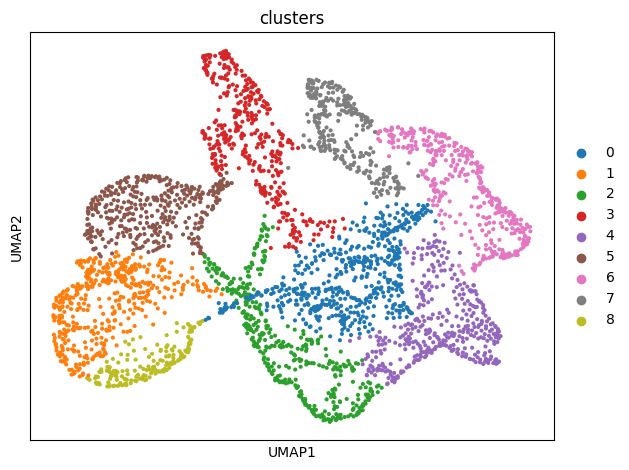

In [17]:
adata = clustering(adata, alpha=1, adata_save_path=results_save_path, cluster_resolution=0.25, 
                   plot_all_cluster_results=False, figsize=figsize, plot_x=plot_x, plot_y=plot_y)

[<Axes: title={'center': 'clusters'}, xlabel='spatial1', ylabel='spatial2'>]

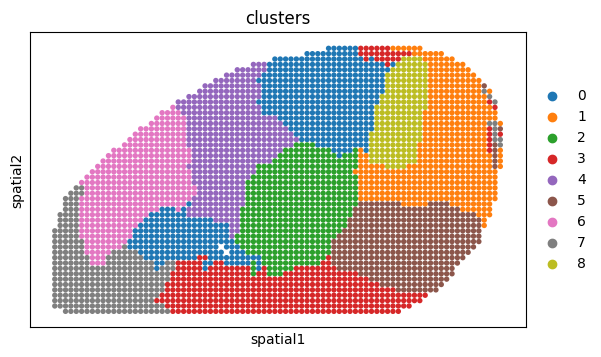

In [18]:
adata.obsm['spatial'] = adata.obs[['y', 'x']].values
sc.pl.spatial(adata, color='clusters', spot_size=1, show=False)

In [ ]:
for c in adata.obs['clusters'].unique():
    temp_adata = adata[adata.obs['clusters'] == c]
    plt.figure(figsize=(4,6))
    plt.scatter(adata.obs['x'].values, adata.obs['y'].values, c='#d3d3d3', s=10)
    plt.scatter(temp_adata.obs['x'].values, temp_adata.obs['y'].values, c='#FF8C00', s=10)
    # plt.savefig(f'{path}/{c}.png')
    plt.show()